In [16]:
import os

import cv2
import rasterio
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

from pathlib import Path
from pyproj import CRS, Transformer
from rasterio.features import rasterize

from shapely.geometry import mapping
from shapely.ops import transform

from tqdm.auto import tqdm

# HSV green detection

In [2]:
def green_space(img):
    # Check if the image loaded successfully
    if img is None:
        raise ValueError("Failed to load the image. Check the file path.")

    # Convert image to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define green range for foliage detection
    lower_green = np.array([30, 40, 40])  # Adjusted for broader green detection
    upper_green = np.array([80, 255, 255])
    mask_green = cv2.inRange(hsv_img, lower_green, upper_green)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask_green = cv2.dilate(mask_green, kernel, iterations=2)  # Connect fragmented regions
    mask_green = cv2.erode(mask_green, kernel, iterations=1)  # Remove small noise
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)  # Close small gaps

    return mask_green

# RGB green detection

In [3]:
def green_space_rgb(img):

    # --- RGB thresholding ---
    # We want G high, R and B relatively lower.
    lower_rgb = np.array([93, 130, 54])   # R,G,B minimums
    upper_rgb = np.array([169, 200, 108])   # R,G,B maximums
    mask = cv2.inRange(img, lower_rgb, upper_rgb)

    # --- Clean up mask ---
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.erode(mask,  kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

# Building area estimation

In [6]:
def create_building_and_circle_masks(building_geom, tif_path, radius_m=100):
    """
    building_geom : shapely Polygon in EPSG:4326 (lon/lat)
    tif_path      : path to your georeferenced .tif (may be projected or geographic)
    radius_m      : buffer radius in meters
    
    returns: (building_mask, circle_mask) each a (H×W) uint8 array
    """
    # 1) Open the raster to grab its transform, size & CRS
    with rasterio.open(tif_path) as src:
        out_shape  = (src.height, src.width)
        affine     = src.transform
        raster_crs = src.crs

    # 2) Prepare CRS objects
    geom_crs = CRS.from_epsg(4326)

    # 3) Reproject building into raster CRS if needed for building_mask
    if raster_crs.is_projected:
        to_rast       = Transformer.from_crs(geom_crs, raster_crs, always_xy=True).transform
        building_rast = transform(to_rast, building_geom)
    else:
        # raster is geographic (EPSG:4326), building_geom is already in that CRS
        building_rast = building_geom

    # 4) Rasterize the building footprint
    building_mask = rasterize(
        [(mapping(building_rast), 1)],
        out_shape=out_shape,
        transform=affine,
        fill=0,
        dtype='uint8'
    )

    # 5) Build the circle buffer (in metres) then reproject back to raster CRS
    if raster_crs.is_projected:
        # buffer directly in projected CRS
        circle = building_rast.centroid.buffer(radius_m)
    else:
        # buffer in a local Azimuthal Equidistant (metre‐based) around centroid
        cent = building_geom.centroid
        lon0, lat0 = cent.x, cent.y
        aeqd_crs  = CRS.from_proj4(
            f"+proj=aeqd +lat_0={lat0} +lon_0={lon0} +datum=WGS84 +units=m")
        to_aeqd = Transformer.from_crs(geom_crs, aeqd_crs, always_xy=True).transform
        to_geo  = Transformer.from_crs(aeqd_crs, geom_crs, always_xy=True).transform

        b_aeqd = transform(to_aeqd, building_geom)
        circ_aeqd = b_aeqd.centroid.buffer(radius_m)
        circle = transform(to_geo, circ_aeqd)

    # 6) Rasterize the circle
    circle_mask = rasterize(
        [(mapping(circle), 1)],
        out_shape=out_shape,
        transform=affine,
        fill=0,
        dtype='uint8'
    )

    return building_mask, circle_mask

In [9]:
gdf = gpd.read_file('../data/yerevan_buildings_clean.geojson')

In [ ]:
indices = gdf.img_id.unique().astype(str).tolist()

def get_paths(id):
    img_name = [f for f in os.listdir('data') if f.startswith(f'{id}_')][0]
    return os.path.join('data', img_name), os.path.join('../georeferenced_images', f'{id}.tif')

Get green area ratio

In [ ]:
def get_area_ratio(row):
    index = row.img_id
    jpg_path, tif_path = get_paths(str(index))
    green_mask = green_space_rgb(cv2.imread(jpg_path))
    building_geom = row.geometry
    building_mask, circle_mask = create_building_and_circle_masks(building_geom, tif_path, radius_m=100)
    total_area = circle_mask.sum()
    green_area = np.logical_and(green_mask/255, circle_mask).sum()
    ratio = green_area / total_area
    return ratio

In [8]:
from tqdm.auto import tqdm
tqdm.pandas()

# Unlock to calculate all the ratios
# gdf['green_area_percentage'] = gdf.progress_apply(get_area_ratio, axis=1)
# TODO: save the green_area_percentage to a file

In [13]:
def get_sub_area(row):
    index = row.img_id
    jpg_path, tif_path = get_paths(str(index))
    img = cv2.imread(jpg_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    green_mask = green_space_rgb(img)
    building_geom = row.geometry
    building_mask, circle_mask = create_building_and_circle_masks(building_geom, tif_path, radius_m=100)
    total_area = circle_mask.sum()
    green_area = np.logical_and(green_mask/255, circle_mask).sum()
    ratio = green_area / total_area
    return img_rgb, green_mask, building_mask, circle_mask, ratio

In [15]:
img, green_mask, building_mask, circle_mask, ratio = get_sub_area(gdf.iloc[1381])

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data'

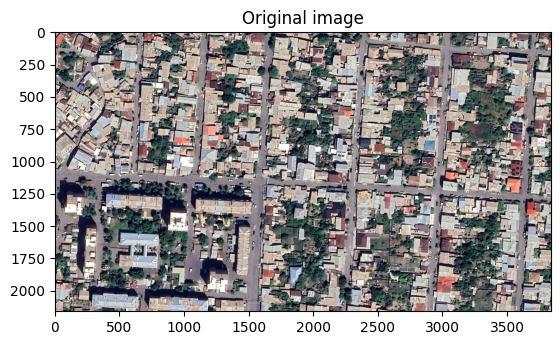

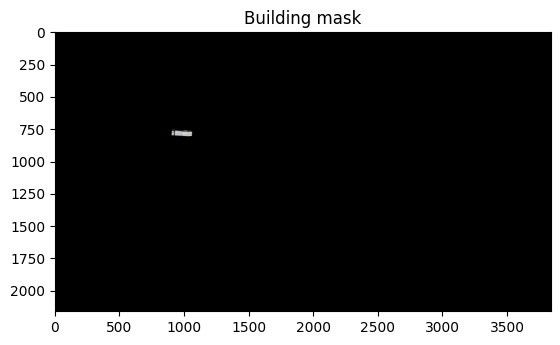

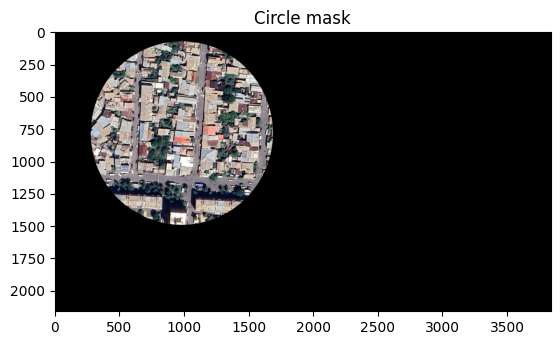

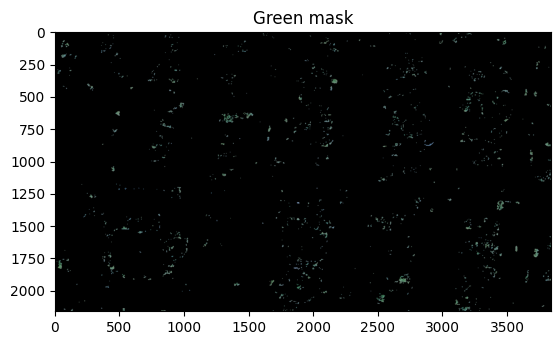

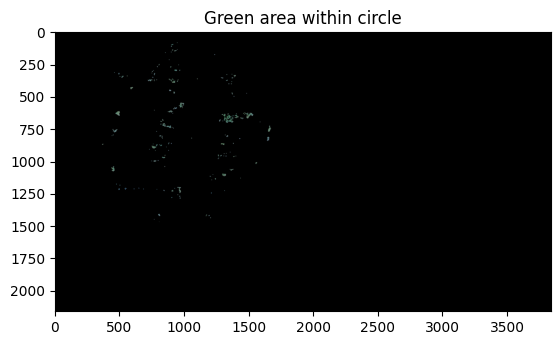

In [11]:
plt.imshow(img)
plt.title('Original image')
plt.show()

sub_img = np.bitwise_and(img, np.stack([building_mask*255]*3, axis=-1))
plt.title('Building mask')
plt.imshow(sub_img)
plt.show()

sub_img = np.bitwise_and(img, np.stack([circle_mask*255]*3, axis=-1))
plt.title('Circle mask')
plt.imshow(sub_img)
plt.show()

sub_img = np.bitwise_and(img, np.stack([green_mask]*3, axis=-1))
plt.title('Green mask')
plt.imshow(sub_img)
plt.show()

sub_img = np.bitwise_and(img, np.stack([np.logical_and(green_mask, circle_mask)*255]*3, axis=-1))
plt.title('Green area within circle')
plt.imshow(sub_img, cmap='gray')
plt.show()

In [17]:
def calculate_green_areas(buildings, image_folder, georeferenced_folder, radius_m=100):
    """
    Adds a green_area_percentage column to the buildings GeoDataFrame.
    
    Parameters:
        buildings (GeoDataFrame): must contain 'img_id' and 'geometry' (in EPSG:4326)
        image_folder (str): path to folder with RGB .jpg images
        georeferenced_folder (str): path to folder with .tif georeferenced images
        radius_m (int): buffer radius in meters (default=100)

    Returns:
        GeoDataFrame with 'green_area_percentage' column
    """

    def get_paths(img_id):
        img_name = [f for f in os.listdir(image_folder) if f.startswith(f'{img_id}_')][0]
        jpg_path = os.path.join(image_folder, img_name)
        tif_path = os.path.join(georeferenced_folder, f'{img_id}.tif')
        return jpg_path, tif_path

    def get_green_ratio(row):
        try:
            jpg_path, tif_path = get_paths(str(row.img_id))
            img = cv2.imread(jpg_path)
            if img is None:
                raise FileNotFoundError(f"Image not found or failed to load: {jpg_path}")
            green_mask = green_space(img)
            building_mask, circle_mask = create_building_and_circle_masks(row.geometry, tif_path, radius_m)
            total_area = circle_mask.sum()
            green_area = np.logical_and(green_mask/255, circle_mask).sum()
            return green_area / total_area if total_area > 0 else 0.0
        except Exception as e:
            print(f"Error for img_id {row.img_id}: {e}")
            return np.nan

    tqdm.pandas(desc="Calculating green area percentage")
    buildings = buildings.copy()
    buildings['green_area_percentage'] = buildings.progress_apply(get_green_ratio, axis=1)
    return buildings


In [19]:
updated_gdf = calculate_green_areas(buildings=gdf, image_folder='../images', georeferenced_folder='../georeferenced_images')
# updated_gdf.to_file("buildings_with_green_area.geojson", driver="GeoJSON")

Calculating green area percentage:   0%|          | 0/76205 [00:00<?, ?it/s]

In [20]:
updated_gdf.to_file("../results/yerevan_buildings_with_green_space.geojson", driver="GeoJSON")